In [1]:
import cv2
import glob
import os
import pandas as pd
import numpy as np
import subprocess

# general imports
from copy import deepcopy
from pathlib import Path
from PIL import Image, ImageOps
from scipy.signal import resample

# for reading and displaying images
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, MSELoss, SmoothL1Loss
from torch.optim import Adam, SGD, lr_scheduler, LBFGS, RAdam, AdamW
from torch.utils.data import DataLoader
from torchmetrics import PeakSignalNoiseRatio
from adabelief_pytorch import AdaBelief
#from torchviz import make_dot

In [2]:
def generate_cdr1_to_cdr3_pdb(path, keepABC=True, lresidues=False):
    list_residues = ['START']
    with open(path, 'r') as f: # needs to be Chothia-numbered
        content = f.readlines()
        header_lines_important = range(4)
        header_lines = [content[i][0]=='R' for i in range(len(content))].count(True)
        h_range = range(26, 103)
        l_range = range(24, 98)
        chain_range = slice(21, 22)
        res_range = slice(23, 26)
        res_extra_letter = 26 #sometimes includes a letter 'A', 'B', 'C', ...
        h_chain_key = 'HCHAIN'
        l_chain_key = 'LCHAIN'
        idx_list = list(header_lines_important)
        new_path = path[:-4] + '_CDR1_to_CDR3' + path[-4:]
        
        # Getting the names of the heavy and light chains
        line = content[header_lines_important[-1]]
        if line.find(h_chain_key) != -1:
            h_pos = line.find(h_chain_key) + len(h_chain_key) + 1
            h_chain = line[h_pos:h_pos+1]
            
            # Obtaining the CDR1 to CDR3 lines for both chains
            for i, line in enumerate(content[header_lines:]):
                if line[chain_range].find(h_chain) != -1 and int(line[res_range]) in h_range:
                    if line[res_extra_letter] == ' ' or keepABC == True:
                        idx_list.append(i+header_lines)
                        if lresidues == True:
                            full_res = line[chain_range] + line[res_range] + line[res_extra_letter]
                            if full_res != list_residues[-1]:
                                list_residues.append(full_res)
        
        #line = content[header_lines_important[-1]]                       
        #if line.find(l_chain_key) != -1:
        #    l_pos = line.find(l_chain_key) + len(l_chain_key) + 1
        #    l_chain = line[l_pos:l_pos+1]
            
        #    # This separation ensures that heavy chain residues are enlisted first
        #    for i, line in enumerate(content[header_lines:]):
        #        if line[chain_range].find(l_chain) != -1 and int(line[res_range]) in l_range:
        #            if line[res_extra_letter] == ' ' or keepABC == True:
        #                idx_list.append(i+header_lines)
        #                if lresidues == True:
        #                    full_res = line[chain_range] + line[res_range] + line[res_extra_letter]
        #                    if full_res != list_residues[-1]:
        #                        list_residues.append(full_res)                   
    
    # List with name of every residue is saved if selected
    if lresidues == True:
        list_residues.append('END')
        np.save('/Users/kevinmicha/Documents/PhD/predicting-affinity/lists_of_residues/'+path[-8:-4]+'.npy', list_residues)
                        
                    
    # Creating new file
    with open(new_path, 'w') as f_new:
        f_new.writelines([content[l] for l in idx_list])

In [3]:
# Getting entries with affinity and antigen information
df = pd.read_csv('sabdab_summary_all.tsv', sep='\t', header=0)[['pdb', 'antigen_type', 'affinity']]
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag']
df.drop_duplicates(keep='first', inplace=True)
df = df[(df.antigen_type.notna()) & (df.antigen_type != 'NA')][['pdb', 'affinity']]
df = df[(df.affinity.notna()) & (df.affinity != 'None')]
df = df[~df['pdb'].isin(pathological)] # Removing pathological cases 
entries = list(df['pdb'])
affinity = list(df['affinity'])
modes = 30 # 'all' if no limit is desired, otherwise a number is required
numbering = ''
selection = '_CDR1_to_CDR3'
folder = str(Path.home() / 'Downloads') + '/all_structures/chothia/'
file_type_input = '.pdb'
dccm_map_path = 'dccm_maps/'

# Uncomment to generate

#for entry in entries:
#    file_name = entry + numbering + selection
#    path = folder + file_name + file_type_input
#    new_path = dccm_map_path + entry
#    generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input) 
#    subprocess.call(['/usr/local/bin/RScript pdb_to_dccm.r ' + str(path) + ' ' + str(new_path) + ' ' + str(modes)], shell=True, stdout=open(os.devnull, 'wb'))#    subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))
#
#
#    if os.path.exists(path):
#        os.remove(path)

In [4]:
dccm_paths = sorted(glob.glob(os.path.join(dccm_map_path, '*.npy')))
selected_entries = [dccm_paths[i][-8:-4] for i in range(len(dccm_paths))]
heavy = np.load('chain_lengths/heavy_lengths.npy').astype(int)
#light = np.load('chain_lengths/light_lengths.npy').astype(int)

assert list(np.load('chain_lengths/selected_entries.npy')) == selected_entries

for entry in selected_entries:
    assert len(np.load('/Users/kevinmicha/Documents/PhD/predicting-affinity/lists_of_residues/'+entry+'.npy'))-2 == heavy[selected_entries.index(entry)] #+ light[selected_entries.index(entry)]

# Uncomment to get the lengths (of the light and heavy chains) and lists of residues

#heavy = []
##light = []

#for entry in selected_entries:
#    file_name = entry + numbering + selection
#    path = folder + file_name + file_type_input
#    new_path = dccm_map_path + entry
#    generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input, keepABC=True, lresidues=True)
#    subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))
#   
#    if os.path.exists(path):
#        os.remove(path)
#    h, l = np.load('/Users/kevinmicha/Downloads/value.npy') # there might be a neat solution
#
#    heavy.append(h)
#    #light.append(l)
#np.save('heavy_lengths.npy', heavy)
##np.save('light_lengths.npy', light)
#np.save('selected_entries.npy', selected_entries)

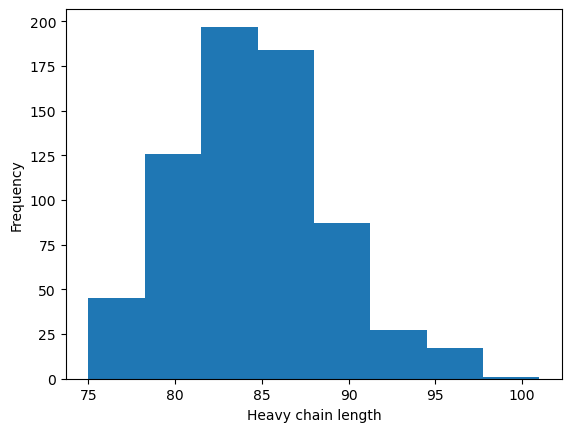

In [5]:
plt.hist(heavy, 8)
plt.xlabel('Heavy chain length')
plt.ylabel('Frequency')
plt.show()

In [6]:
#plt.hist(light, 8)
#plt.xlabel('Light chain length')
#plt.ylabel('Frequency')
#plt.show()

In [7]:
#plt.hist([sum(x) for x in zip(heavy, light)], 8)
#plt.xlabel('Total length')
#plt.ylabel('Frequency')
#plt.show()

In [8]:
# Code that obtains the longest/shortest possible chain

def noABC(residue):
    return residue[:-1]

residue_path = 'lists_of_residues/'
file_residues_paths = sorted(glob.glob(os.path.join('/Users/kevinmicha/Documents/PhD/predicting-affinity/'+residue_path, '*.npy')))
max_res_list = []

for f in file_residues_paths:
    current_list = np.load(f)[1:heavy[selected_entries.index(f[-8:-4])]+1]
    current_list = [x[1:] for x in current_list]
    max_res_list += list(set(current_list).difference(max_res_list))
    
max_res_list = sorted(max_res_list, key=noABC)
min_res_list = list(dict.fromkeys([x for x in max_res_list]))
max_res_list = [x.strip() for x in max_res_list]

for f in file_residues_paths:
    current_list = np.load(f)[1:heavy[selected_entries.index(f[-8:-4])]+1]
    current_list = [x[1:] for x in current_list]
    min_res_list = sorted(list(set(current_list).intersection(min_res_list)))

min_res_list = [x.strip() for x in min_res_list]

print('The longest chain has ' + str(len(max_res_list)) + ' residues, while the shortest has ' + str(len(min_res_list)))

The longest chain has 120 residues, while the shortest has 44


In [222]:
def generate_masked_image(img, idx=idx_new, res_list=max_res_list, file_residues_paths=file_residues_paths, mode='fully-extended'):
    
    f = file_residues_paths[idx]
    
    current_list = np.load(f)[1:]#heavy[selected_entries.index(f[-8:-4])]+1]
    current_list = [x[1:].strip() for x in current_list]

    
    if mode == 'fully-cropped':
        idx_list = [i for i in range(len(current_list)) if current_list[i] in res_list]
        mask = img[idx_list,:][:,idx_list] 
        
    
    elif mode == 'fully-extended':
        max_res = len(res_list)
        mask = np.zeros((max_res, max_res))
        idx_list = [i for i in range(max_res) if res_list[i] in current_list]
        for k, i in enumerate(idx_list):
            for l, j in enumerate(idx_list):
                mask[i, j] = img[k, l]

    else:
        raise NotImplementedError('Unknown mode: choose between fully-cropped and fully-extended')
        
    return mask

In [14]:
# loading training images
imgs = []
kds = []
labels = []
data_path = '/Users/kevinmicha/Documents/PhD/predicting-affinity/' + dccm_map_path
file_paths = sorted(glob.glob(os.path.join(data_path, '*.npy')))
for f in file_paths:
    pdb_id = f[-8:-4]
    if pdb_id in selected_entries:
        idx = entries.index(pdb_id)
        idx_new = selected_entries.index(pdb_id)
        labels.append(pdb_id)
        imgs.append(generate_masked_image(np.load(f), idx_new, max_res_list, file_residues_paths, 'fully-extended'))
        kds.append(np.log10(np.float32(affinity[idx])))

assert labels == selected_entries

for pdb in selected_entries:
    assert np.float16(10**kds[selected_entries.index(pdb)] == np.float16(df[df['pdb']==pdb]['affinity'])).all()

# converting the list to numpy array
#train_x = np.array(np.triu(imgs))
train_x = np.array(imgs)
# defining the target
train_y = np.array(kds)

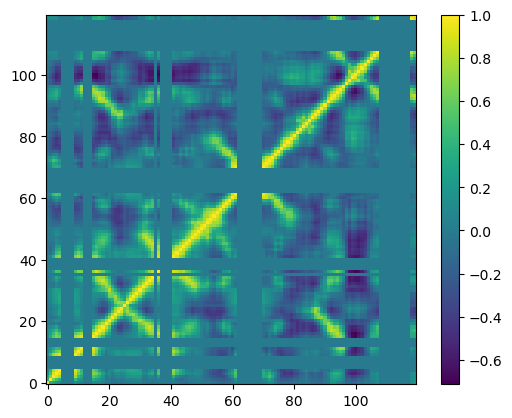

In [15]:
plt.imshow(train_x[17].reshape(train_x.shape[-1], train_x.shape[-1]), origin='lower')
plt.colorbar()

In [16]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.01)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((677, 120, 120), (677,)), ((7, 120, 120), (7,)))

In [17]:
# converting training images into torch format
train_x = train_x.reshape(train_x.shape[0], 1, train_x.shape[1], train_x.shape[1])
train_x = train_x.astype(np.float32)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(np.float32).reshape(train_y.shape[0], 1)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([677, 1, 120, 120]), torch.Size([677, 1]))

In [18]:
# converting validation images into torch format
val_x = val_x.reshape(val_x.shape[0], 1, train_x.shape[2], train_x.shape[2])
val_x = val_x.astype(np.float32)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(np.float32).reshape(val_y.shape[0], 1)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([7, 1, 120, 120]), torch.Size([7, 1]))

In [19]:
n_filters = 2
filter_size = 21
pooling_size = 4
fully_connected_input = n_filters * ((train_x.shape[2] - filter_size + 1) // pooling_size) ** 2

class MultiLabelNN(Module):
    def __init__(self):
        super(MultiLabelNN, self).__init__()
        self.conv1 = Conv2d(1, n_filters, filter_size)
        self.conv1.weight.data = torch.tril(self.conv1.weight.data) + torch.transpose(torch.tril(self.conv1.weight.data), 2, 3)
        #self.conv1.weight.data.fill_(1e-5)
        self.pool = MaxPool2d(pooling_size, pooling_size)
        #self.conv2 = Conv2d(16, 32, 3)
        #self.conv2.weight.data = torch.tril(self.conv2.weight.data) + torch.transpose(torch.tril(self.conv2.weight.data), 2, 3)
        #self.conv2.weight.data = torch.transpose(self.conv2.weight.data, 2, 3)
        self.relu = ReLU()
        self.fc1 = Linear(fully_connected_input, 1, bias=False)
        #self.fc2 = Linear(128, 1)
        self.dropit = Dropout(p=0.05)
        #self.fc3 = Linear(128, 64)
        #self.fc4 = Linear(64, 1)

    def forward(self, x):
       #shape of x is (b_s, 32,32,1)
        x = self.conv1(x) + torch.transpose(self.conv1(x), 2, 3)#shape of x is (b_s, 28,28,132)
        #x = self.relu(x)
        x = self.pool(x) #shape of x now becomes (b_s X 14 x 14 x 32)
        #x = self.conv2(x) # shape(b_s, 10x10x64)
        x = self.relu(x)#size is (b_s x 10 x 10 x 64)
        x = x.view(x.size(0), -1) # shape of x is now(b_s*2, 3200)
        #this is the problem 
        #you can fc1 to be of shape (6400,1024) and that will work 
        x = self.dropit(x)
        x = self.fc1(x)
        #x = self.relu(x)
        #x = self.fc2(x)
        #x = self.relu(x)
        #x = self.fc3(x)
        #x = self.relu(x)
        #x = self.fc4(x)


        return x.float()


In [20]:
# defining the model
model = MultiLabelNN()
# defining the optimizer
#optimizer = Adam(model.parameters(), lr=2e-3)
#optimizer = AdamW(model.parameters(), lr=2e-3)
optimizer = AdaBelief(model.parameters(), lr=2.5e-3, eps=1e-8) #try lr 2e-3
#optimizer = SGD(model.parameters(), lr=9e-4)
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, min_lr=3e-4, factor=0.1)
# defining the loss function
criterion = MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
MultiLabelNN(
  (conv1): Conv2d(1, 2, kerne

In [21]:
def train(epoch):
    model.train()
    tr_loss = 0
    batch_size = 32
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)

    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    
    permutation = torch.randperm(x_train.size()[0])
    #val_indices = torch.randperm(x_val.size()[0])[:1]

    for i in range(0, x_train.size()[0], batch_size):

        
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        
        
        # prediction for training and validation set
        output_train = model(batch_x)

        # computing the training and validation loss
        loss_train = criterion(output_train, batch_y)

        # computing the updated weights of all the model parameters
        loss_train.backward()
        optimizer.step()
        
        # clearing the Gradients of the model parameters
        optimizer.zero_grad(set_to_none=True)
        
        tr_loss += loss_train.item() * batch_size / x_train.size()[0]
    output_val = model(x_val)#[val_indices])
    loss_val = criterion(output_val, y_val)#[val_indices])
    #scheduler.step(loss_val)
    train_losses.append(tr_loss)
    val_losses.append(loss_val)
    
    # printing the validation loss
    print('Epoch : ',epoch+1, '\t', 'train loss: ', tr_loss, 'val loss :', loss_val)
    print(output_val)
    print(y_val)#[val_indices])
        
    return tr_loss, loss_val


In [22]:
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []

In [136]:
# defining the number of epochs
n_max_epochs = 10

# training the model
for epoch in range(n_max_epochs):
    tr_loss, val_loss = train(epoch)
    if tr_loss < 0.05 and val_loss < 0.1:
        break

Epoch :  1 	 train loss:  0.9909747840734846 val loss : tensor(0.8837, grad_fn=<MseLossBackward0>)
tensor([[-7.7857],
        [-6.8551],
        [-8.8362],
        [-7.0921],
        [-3.9556],
        [-9.0372],
        [-7.2199]], grad_fn=<MmBackward0>)
tensor([[-8.2147],
        [-8.4473],
        [-7.9208],
        [-8.0506],
        [-4.5086],
        [-9.2007],
        [-8.3936]])
Epoch :  2 	 train loss:  0.8778246213273423 val loss : tensor(0.2380, grad_fn=<MseLossBackward0>)
tensor([[ -7.9531],
        [ -8.6395],
        [ -8.7276],
        [ -7.9551],
        [ -4.8132],
        [-10.0866],
        [ -8.5443]], grad_fn=<MmBackward0>)
tensor([[-8.2147],
        [-8.4473],
        [-7.9208],
        [-8.0506],
        [-4.5086],
        [-9.2007],
        [-8.3936]])
Epoch :  3 	 train loss:  0.8312632519878348 val loss : tensor(0.6766, grad_fn=<MseLossBackward0>)
tensor([[-7.4669],
        [-6.9470],
        [-7.8534],
        [-7.0326],
        [-3.5903],
        [-9.0212],


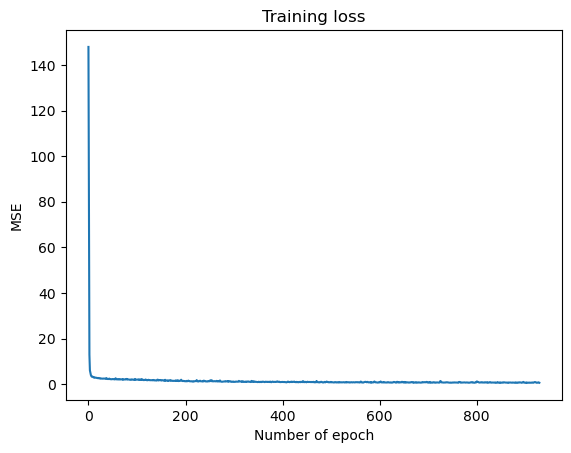

In [137]:
plt.plot([train_losses[i] for i in range(len(train_losses))])
plt.title('Training loss')
plt.xlabel('Number of epoch')
plt.ylabel('MSE')
plt.show()

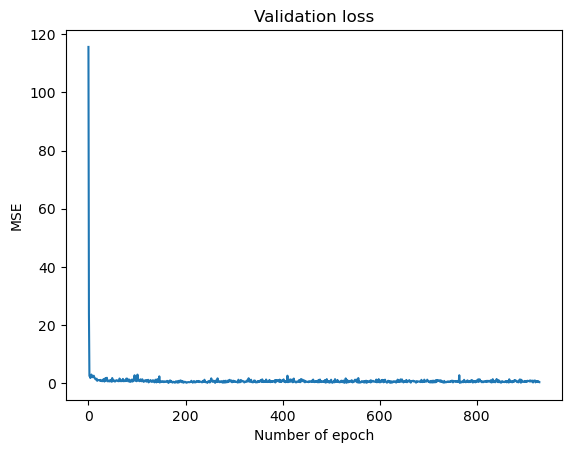

In [138]:
plt.plot([val_losses[i].detach().numpy() for i in range(len(val_losses))])
plt.title('Validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('MSE')
plt.show()

In [139]:
model.eval()
model(Variable(train_x[58:65]))

tensor([[-6.7883],
        [-7.5922],
        [-3.4577],
        [-7.3645],
        [-7.1623],
        [-8.2977],
        [-7.9736]], grad_fn=<MmBackward0>)

In [140]:
Variable(train_y[58:65])

tensor([[-6.5086],
        [-7.0000],
        [-3.6990],
        [-7.3979],
        [-7.2757],
        [-7.9245],
        [-7.5867]])

In [141]:
file_paths

['/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1a4k.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1aj7.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1axs.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1bj1.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1bvk.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1c12.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1c5c.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1ct8.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1cz8.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1d6v.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1dbb.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1dee.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1dl7.npy',
 '/Users/kevinmicha/Docum

In [206]:
entry = '1t66'
file_name = entry + numbering + selection
path = folder + file_name + file_type_input
new_path = download_path + entry + '_map'
generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input, lresidues=True)  
subprocess.call(['/usr/local/bin/RScript pdb_to_dccm.r ' + str(path) + ' ' + str(new_path) + ' ' + str(modes)], shell=True, stdout=open(os.devnull, 'wb'))#    subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))
subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))

if os.path.exists(path):
    os.remove(path)
h, l = np.load('/Users/kevinmicha/Downloads/value.npy') 

In [227]:
f = download_path + entry + '_map' + '.npy'
res_path = np.array([download_path + entry + '_residues' + '.npy'])
test_array = generate_masked_image(np.load(f), idx=0, res_list=max_res_list, file_residues_paths=res_path, mode='fully-extended')
test_sample = torch.from_numpy(test_array.reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32))

In [229]:
model.eval()
model(test_sample)

tensor([[-6.7474]], grad_fn=<MmBackward0>)

In [230]:
prediction = 10**model(test_sample).detach().numpy()
prediction

array([[1.7890132e-07]], dtype=float32)

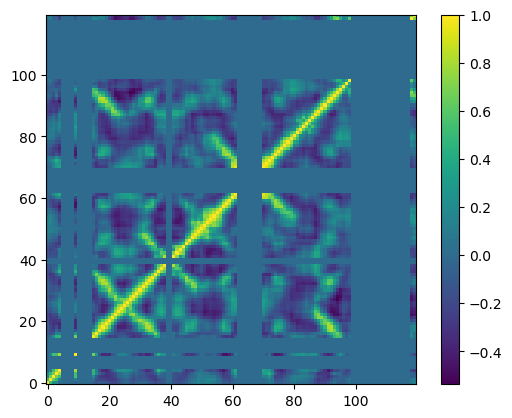

In [231]:
plt.imshow(test_sample[0,0,...], origin='lower')
plt.colorbar()

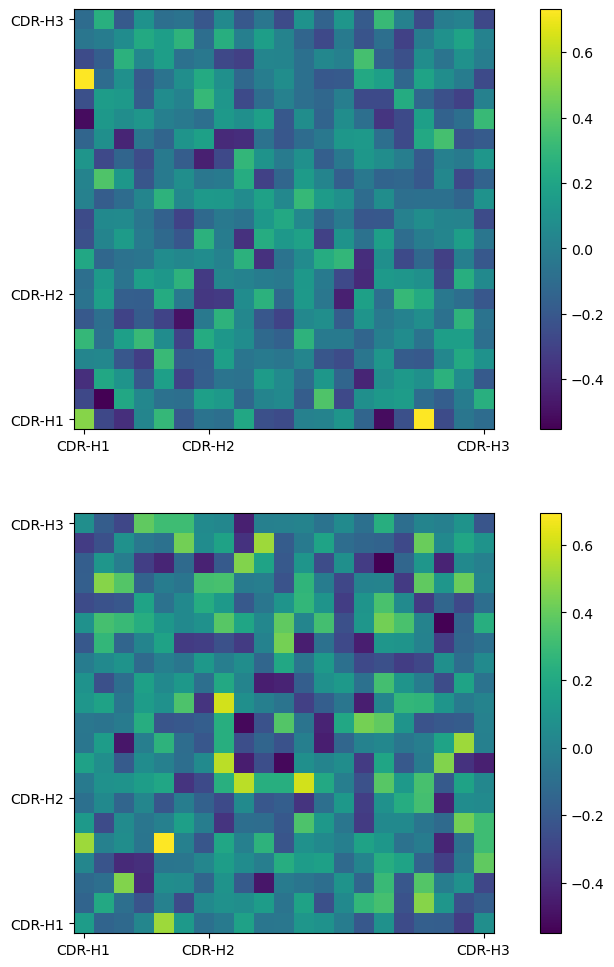

In [232]:
import itertools

fig, axs = plt.subplots(n_filters, 1, figsize=(12, 12))
conv_filters = deepcopy(model.conv1.weight.data.numpy())
                           
for i, j in itertools.product(range(n_filters), range(1)):
    im = axs[i].imshow(conv_filters[i+j][0], origin='lower')
    axs[i].set_xticks([0, 6.25, 20], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    axs[i].set_yticks([0, 6.25, 20], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    plt.colorbar(im, ax=axs[i])

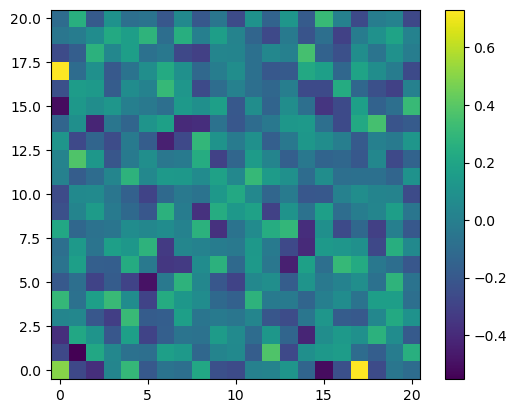

In [233]:
plt.imshow(np.mean(conv_filters[0,...], axis=0), origin='lower')
plt.colorbar()

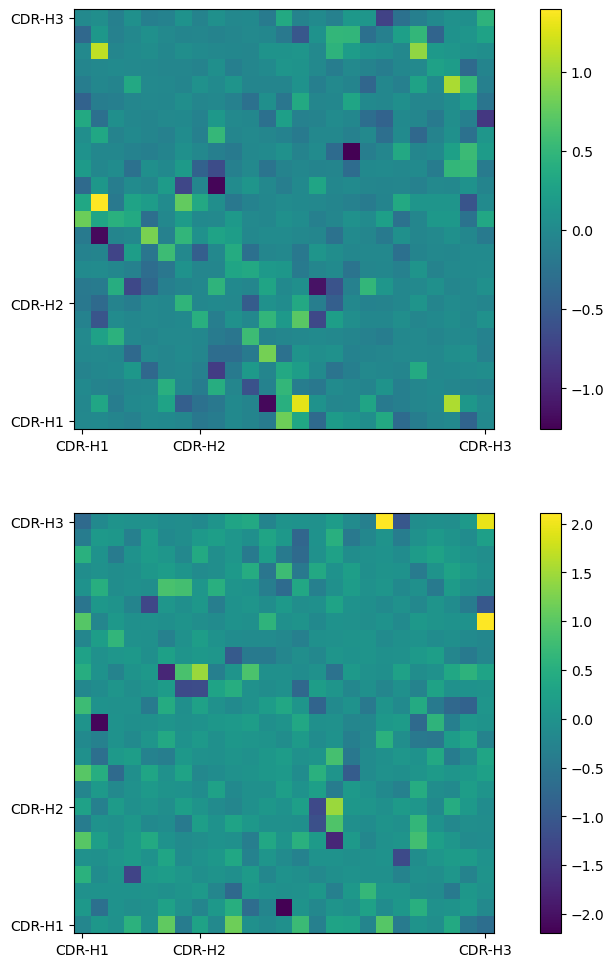

In [234]:
fig, axs = plt.subplots(n_filters, 1, figsize=(12, 12))

fully_connected = deepcopy(model.fc1.weight.data.numpy().reshape(n_filters, 625))
#fully_connected = np.where(abs(fully_connected)<0.05, 0, fully_connected)

for i, j in itertools.product(range(n_filters), range(1)):
    im = axs[i].imshow(fully_connected[i].reshape(25, 25), origin='lower')
    axs[i].set_xticks([0, 7, 24], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    axs[i].set_yticks([0, 7, 24], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    plt.colorbar(im, ax=axs[i])


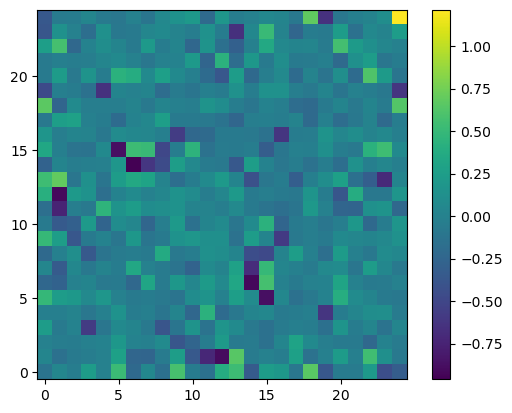

In [235]:
plt.imshow(np.mean(fully_connected.reshape(n_filters, 25, 25), axis=0), origin='lower')
plt.colorbar()

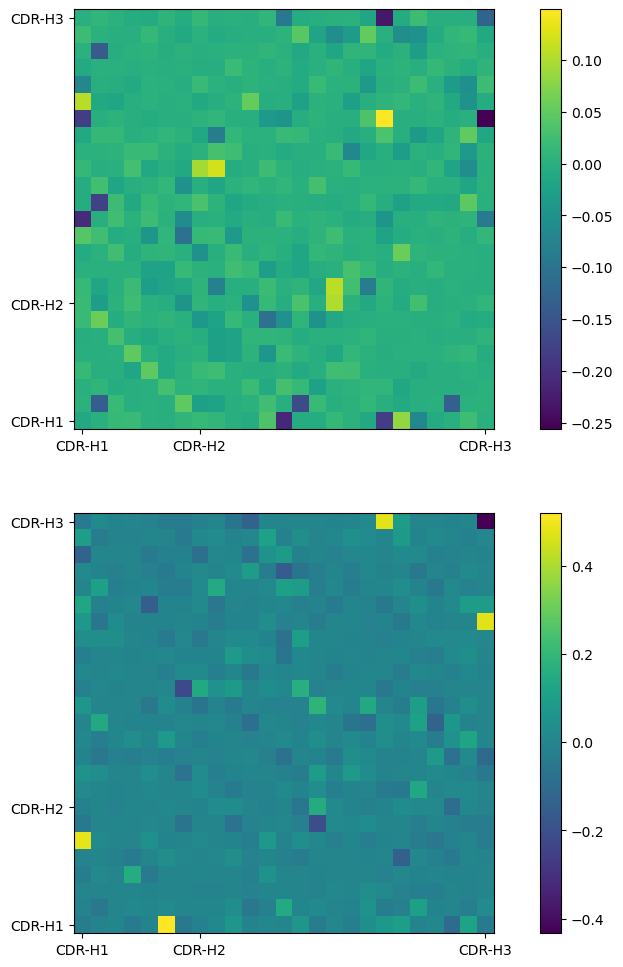

In [236]:
fig, axs = plt.subplots(n_filters, 1, figsize=(12, 12))

img = np.zeros((25, 25))
for i, j in itertools.product(range(n_filters), range(1)):
    conv_bank = cv2.resize(conv_filters[i,0,...], dsize=(25, 25), interpolation=cv2.INTER_AREA)
    #new_img = np.multiply(np.where(conv_bank<-3,0,conv_bank), fully_connected[i].reshape(15, 15)) 
    new_img = np.multiply(conv_bank, fully_connected[i].reshape(25, 25)) #+ model.fc1.bias.data.numpy()
    im = axs[i].imshow(new_img, origin='lower')
    axs[i].set_xticks([0, 7, 24], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    axs[i].set_yticks([0, 7, 24], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    plt.colorbar(im, ax=axs[i])
    img += new_img

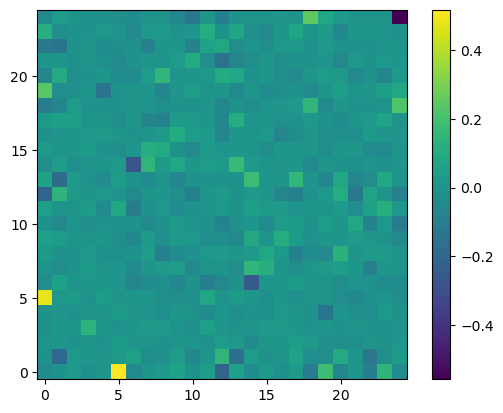

In [237]:
#blue = "need blue in dccm"
#yellow = "need red in dccm"
plt.imshow(np.where(abs(img)<0.002, 0, img), origin='lower')
plt.colorbar()
plt.show()

In [238]:
img.sum()

0.267060486566578

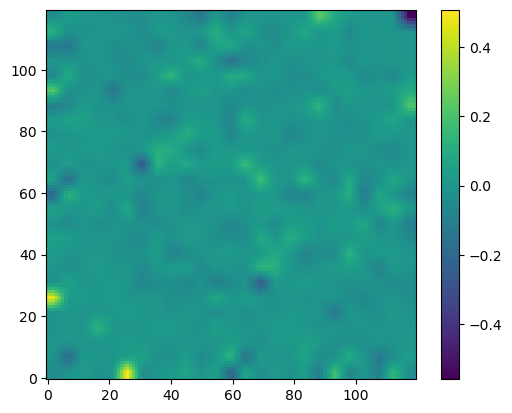

In [254]:
plt.imshow(cv2.resize(img, dsize=(train_x.shape[2], train_x.shape[2])), origin='lower')
plt.colorbar()

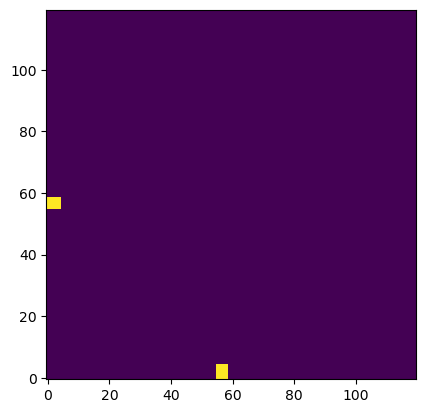

In [255]:
#Arbitrary mask analysis
test_mask = np.zeros((train_x.shape[2], train_x.shape[2]))
test_mask[:5, 55:59] = 1
test_mask += np.transpose(test_mask)
plt.imshow(test_mask, origin='lower')

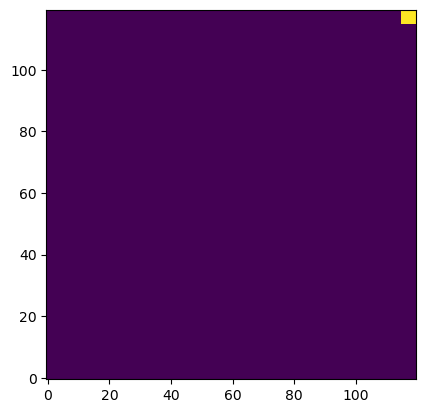

In [256]:
#CDR-H3 analysis
cdr3_mask = np.zeros((train_x.shape[2], train_x.shape[2]))
cdr3_mask[-5:, -5:] = 1
plt.imshow(cdr3_mask, origin='lower')

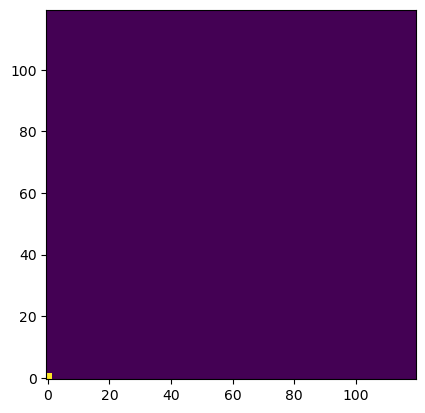

In [257]:
#CDR-H1 analysis
cdr1_mask = np.zeros((train_x.shape[2], train_x.shape[2]))
cdr1_mask[:2, :2] = 1
plt.imshow(cdr1_mask, origin='lower')

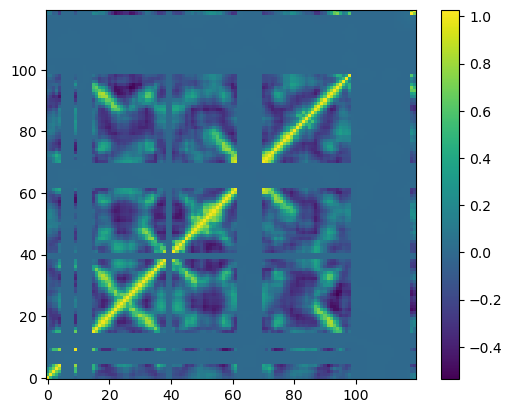

In [277]:
img_factor = -0.05
cdr3_factor = 0
cdr1_factor = 0
test_factor = 0


ideal = test_array + img_factor * cv2.resize(img, dsize=(train_x.shape[2], train_x.shape[2])) + cdr3_factor * cdr3_mask  + cdr1_factor * cdr1_mask + test_factor * test_mask
plt.imshow(ideal, origin='lower')
plt.colorbar()

In [278]:
model.eval()
new_prediction = 10**model(torch.from_numpy(ideal.reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32))).detach().numpy()
per_change = ((prediction - new_prediction) / prediction * 100)[0][0]
print(new_prediction)
print('Adding/subtracting the obtained map with a factor of', img_factor, 'makes Kd smaller by', per_change, '%')

[[1.4125456e-07]]
Adding/subtracting the obtained map with a factor of -0.05 makes Kd smaller by 21.04331 %


In [159]:
cdr1_coord = range(6)
cdr2_coord = range(25, 32)
cdr3_coord = range(72, 76)
beta11_coord = range(8, 13)
beta12_coord = range(20, 25)
beta13_coord = range(32, 35)
beta14_coord = range(66, 72)
beta21_coord = range(42, 48)
beta22_coord = range(51, 58)
alpha_coord = range(60, 63)

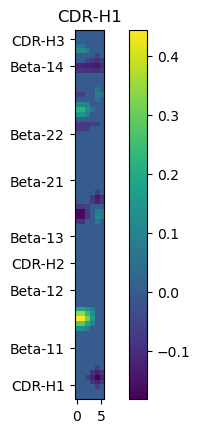

In [160]:
cdr1_corr = cv2.resize(img, dsize=(76, 76))[:, cdr1_coord]
plt.imshow(np.where(abs(cdr1_corr)<abs(cdr1_corr).max()/8, 0, cdr1_corr), origin='lower')
plt.yticks([2.5, 10, 22, 27.5, 33, 44.5, 54, 68, 73.5], ['CDR-H1', 'Beta-11', 'Beta-12', 'CDR-H2', 'Beta-13', 'Beta-21', 'Beta-22', 'Beta-14', 'CDR-H3']) 
plt.colorbar()
plt.title('CDR-H1')
plt.show()

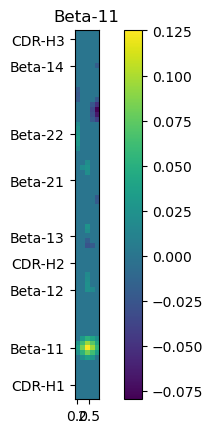

In [161]:
beta11_corr = cv2.resize(img, dsize=(76, 76))[:, beta11_coord]
plt.imshow(np.where(abs(beta11_corr)<abs(beta11_corr).max()/7, 0, beta11_corr), origin='lower')
plt.yticks([2.5, 10, 22, 27.5, 33, 44.5, 54, 68, 73.5], ['CDR-H1', 'Beta-11', 'Beta-12', 'CDR-H2', 'Beta-13', 'Beta-21', 'Beta-22', 'Beta-14', 'CDR-H3']) 
plt.colorbar()
plt.title('Beta-11')
plt.show()

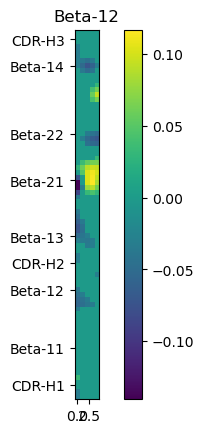

In [162]:
beta12_corr = cv2.resize(img, dsize=(76, 76))[:, beta12_coord]
plt.imshow(np.where(abs(beta12_corr)<abs(beta12_corr).max()/5, 0, beta12_corr), origin='lower')
plt.yticks([2.5, 10, 22, 27.5, 33, 44.5, 54, 68, 73.5], ['CDR-H1', 'Beta-11', 'Beta-12', 'CDR-H2', 'Beta-13', 'Beta-21', 'Beta-22', 'Beta-14', 'CDR-H3']) 
plt.colorbar()
plt.title('Beta-12')
plt.show()

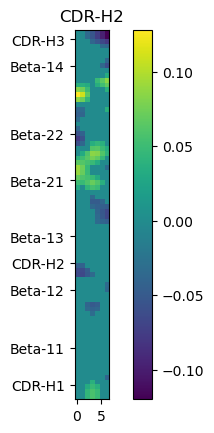

In [163]:
cdr2_corr = cv2.resize(img, dsize=(76, 76))[:, cdr2_coord]
plt.imshow(np.where(abs(cdr2_corr)<abs(cdr2_corr).max()/4, 0, cdr2_corr), origin='lower')
plt.yticks([2.5, 10, 22, 27.5, 33, 44.5, 54, 68, 73.5], ['CDR-H1', 'Beta-11', 'Beta-12', 'CDR-H2', 'Beta-13', 'Beta-21', 'Beta-22', 'Beta-14', 'CDR-H3']) 
plt.colorbar()
plt.title('CDR-H2')
plt.show()

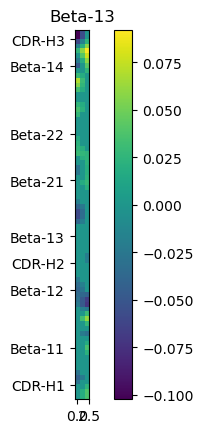

In [164]:
beta13_corr = cv2.resize(img, dsize=(76, 76))[:, beta13_coord]
plt.imshow(np.where(abs(beta13_corr)<abs(beta13_corr).max()/6, 0, beta13_corr), origin='lower')
plt.yticks([2.5, 10, 22, 27.5, 33, 44.5, 54, 68, 73.5], ['CDR-H1', 'Beta-11', 'Beta-12', 'CDR-H2', 'Beta-13', 'Beta-21', 'Beta-22', 'Beta-14', 'CDR-H3']) 
plt.colorbar()
plt.title('Beta-13')
plt.show()

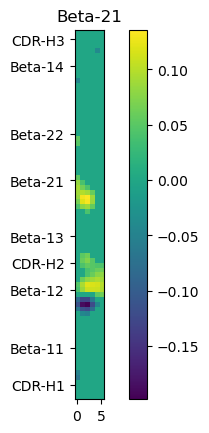

In [165]:
beta21_corr = cv2.resize(img, dsize=(76, 76))[:, beta21_coord]
plt.imshow(np.where(abs(beta21_corr)<abs(beta21_corr).max()/5, 0, beta21_corr), origin='lower')
plt.yticks([2.5, 10, 22, 27.5, 33, 44.5, 54, 68, 73.5], ['CDR-H1', 'Beta-11', 'Beta-12', 'CDR-H2', 'Beta-13', 'Beta-21', 'Beta-22', 'Beta-14', 'CDR-H3']) 
plt.colorbar()
plt.title('Beta-21')
plt.show()

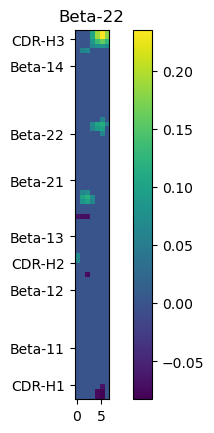

In [166]:
beta22_corr = cv2.resize(img, dsize=(76, 76))[:, beta22_coord]
plt.imshow(np.where(abs(beta22_corr)<abs(beta22_corr).max()/4, 0, beta22_corr), origin='lower')
plt.yticks([2.5, 10, 22, 27.5, 33, 44.5, 54, 68, 73.5], ['CDR-H1', 'Beta-11', 'Beta-12', 'CDR-H2', 'Beta-13', 'Beta-21', 'Beta-22', 'Beta-14', 'CDR-H3']) 
plt.colorbar()
plt.title('Beta-22')
plt.show()

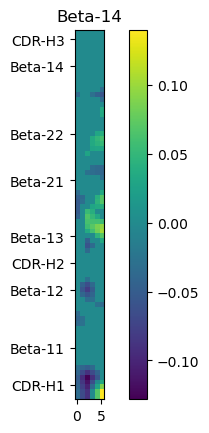

In [167]:
beta14_corr = cv2.resize(img, dsize=(76, 76))[:, beta14_coord]
plt.imshow(np.where(abs(beta14_corr)<abs(beta14_corr).max()/5, 0, beta14_corr), origin='lower')
plt.yticks([2.5, 10, 22, 27.5, 33, 44.5, 54, 68, 73.5], ['CDR-H1', 'Beta-11', 'Beta-12', 'CDR-H2', 'Beta-13', 'Beta-21', 'Beta-22', 'Beta-14', 'CDR-H3']) 
plt.colorbar()
plt.title('Beta-14')
plt.show()

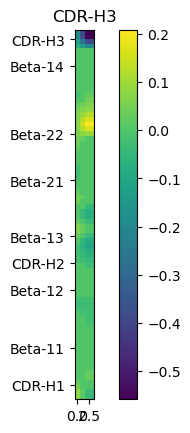

In [168]:
cdr3_corr = cv2.resize(img, dsize=(76, 76))[:, cdr3_coord]
plt.imshow(np.where(abs(cdr3_corr)<abs(cdr3_corr).max()/30, 0, cdr3_corr), origin='lower')
plt.yticks([2.5, 10, 22, 27.5, 33, 44.5, 54, 68, 73.5], ['CDR-H1', 'Beta-11', 'Beta-12', 'CDR-H2', 'Beta-13', 'Beta-21', 'Beta-22', 'Beta-14', 'CDR-H3']) 
plt.colorbar()
plt.title('CDR-H3')
plt.show()

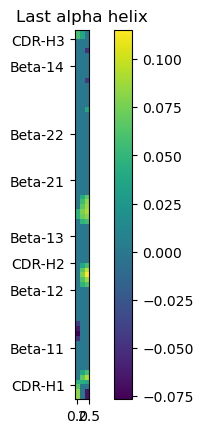

In [169]:
alpha_corr = cv2.resize(img, dsize=(76, 76))[:, alpha_coord]
plt.imshow(np.where(abs(alpha_corr)<abs(alpha_corr).max()/3, 0, alpha_corr), origin='lower')
plt.yticks([2.5, 10, 22, 27.5, 33, 44.5, 54, 68, 73.5], ['CDR-H1', 'Beta-11', 'Beta-12', 'CDR-H2', 'Beta-13', 'Beta-21', 'Beta-22', 'Beta-14', 'CDR-H3']) 
plt.colorbar()
plt.title('Last alpha helix')
plt.show()

/var/folders/4j/fmrt0mln14zcmrb74g6z93bh0000gn/T/ipykernel_86316/1896701973.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coord = np.array([cdr1_coord, beta11_coord, beta12_coord, cdr2_coord, beta13_coord, beta21_coord, beta22_coord, alpha_coord, beta14_coord, cdr3_coord])


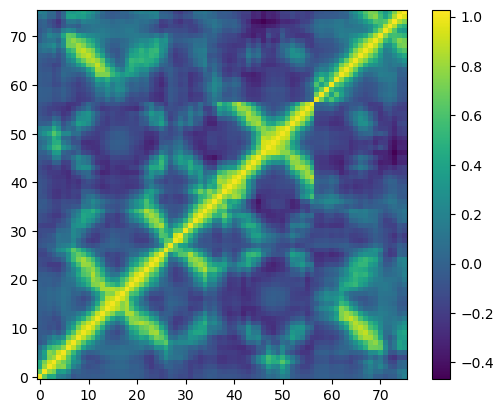

In [170]:
# expanded version, total change: 13.85%
cdr3_factor = -0.05 
cdr1_factor = -0.05 
cdr2_factor = 0.05 #
beta11_factor = -0.05 
beta12_factor = -0.05 
beta13_factor = -0.05 #
beta14_factor = 0.05 # 
beta21_factor = -0.05 
beta22_factor = -0.05 # 
alpha_factor = -0.05 

weights = np.array([cdr1_factor, beta11_factor, beta12_factor, cdr2_factor, beta13_factor, beta21_factor, beta22_factor, alpha_factor, beta14_factor, cdr3_factor])
coord = np.array([cdr1_coord, beta11_coord, beta12_coord, cdr2_coord, beta13_coord, beta21_coord, beta22_coord, alpha_coord, beta14_coord, cdr3_coord])
maps = [cdr1_corr, beta11_corr, beta12_corr, cdr2_corr, beta13_corr, beta21_corr, beta22_corr, alpha_corr, beta14_corr, cdr3_corr]

ideal = np.load(download_path + '1t66.npy')[:76, :76].astype(np.float32) 
for i in range(len(weights)):
    temp = np.pad(maps[i], ((0, 0), (coord[i][0], 76-coord[i][-1]-1)))
    ideal += weights[i] * (temp + np.transpose(temp)) / 2  
plt.imshow(ideal, origin='lower')
plt.colorbar()

In [ ]:
model.eval()
new_prediction = 10**model(torch.from_numpy(cv2.resize(ideal, dsize=(80, 80)).reshape(1, 1, 80, 80).astype(np.float32))).detach().numpy()
per_change = ((prediction - new_prediction) / prediction * 100)[0][0]
print(new_prediction)
print('Kd smaller by', per_change, '%')

In [ ]:
# Save Neural Network checkpoint
#EPOCH = len(val_losses)
#PATH = "model.pt"
#LOSS = tr_loss

#torch.save({
#            'epoch': EPOCH,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': LOSS,
#            }, PATH)

In [ ]:
# Load Neural Network checkpoint

#PATH = "model.pt"
#model = MultiLabelNN()
#optimizer = AdamW(model.parameters(), lr=4e-4)
#checkpoint = torch.load(PATH)
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']

#model.eval()
#10**model(test_sample).detach().numpy()
# - or -
#model.train()

In [ ]:
# Save Neural Network visualization

#x_val = Variable(val_x)
#model = MultiLabelNN()
#yhat = model(x_val)
#make_dot(yhat, params=dict(list(model.named_parameters()))).render("attached", format="png")

### 